In [424]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.impute import KNNImputer
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test,logrank_test
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import statistics as stats
import seaborn as sns
from sklearn.base import clone 
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score,f1_score,precision_score, recall_score,roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pylab as plt

# Applying deep learning to integrate multi-omics data for survival analysis in non-small cell lung cancer patients

## Data Collection and Preprocessing

### Clinical Data

#### Data import

In [83]:
#Import clinical data
clinical = pd.read_table("clinical_patient.txt", delimiter="	",skiprows=4)
clinical = clinical.set_index('PATIENT_ID')
clinical.shape

(566, 37)

In [86]:
#Select columns
clinical=clinical[["AGE","SEX","AJCC_PATHOLOGIC_TUMOR_STAGE","PATH_M_STAGE","PATH_N_STAGE","PATH_T_STAGE",
                   "GENETIC_ANCESTRY_LABEL","OS_STATUS","OS_MONTHS"]]

#Remove patients with missing survival data
clinical.dropna(subset=['OS_STATUS','OS_MONTHS'], inplace=True)

#Inspect missing values
clinical.isnull().sum()

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1327195852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.dropna(subset=['OS_STATUS','OS_MONTHS'], inplace=True)


AGE                            10
SEX                             0
AJCC_PATHOLOGIC_TUMOR_STAGE     2
PATH_M_STAGE                    4
PATH_N_STAGE                    1
PATH_T_STAGE                    0
GENETIC_ANCESTRY_LABEL          0
OS_STATUS                       0
OS_MONTHS                       0
dtype: int64

#### Preprocessing


In [87]:
# AGE
clinical.AGE=clinical.AGE.astype('float')

#Impute missing data as median
clinical.AGE[clinical.AGE.isnull()]=stats.median(clinical.AGE)

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1075466323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.AGE=clinical.AGE.astype('float')
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1075466323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.AGE[clinical.AGE.isnull()]=stats.median(clinical.AGE)
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1075466323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

In [89]:
# AJCC_PATHOLOGIC_TUMOR_STAGE
clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["STAGE I","STAGE IA","STAGE IB","STAGE IC"] for i in clinical.AJCC_PATHOLOGIC_TUMOR_STAGE]]="1"
clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["STAGE II","STAGE IIA","STAGE IIB","STAGE IIC"] for i in clinical.AJCC_PATHOLOGIC_TUMOR_STAGE]]="2"
clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["STAGE III","STAGE IIIA","STAGE IIIB","STAGE IIIC"] for i in clinical.AJCC_PATHOLOGIC_TUMOR_STAGE]]="3"
clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["STAGE IV","STAGE IV","STAGE IV","STAGE IV"] for i in clinical.AJCC_PATHOLOGIC_TUMOR_STAGE]]="4"

clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[clinical.AJCC_PATHOLOGIC_TUMOR_STAGE.isnull()]=stats.mode(clinical.AJCC_PATHOLOGIC_TUMOR_STAGE)

clinical['AJCC_PATHOLOGIC_TUMOR_STAGE'] = clinical['AJCC_PATHOLOGIC_TUMOR_STAGE'].astype(pd.CategoricalDtype(categories=sorted(clinical['AJCC_PATHOLOGIC_TUMOR_STAGE'].unique()), ordered=True))
clinical['AJCC_PATHOLOGIC_TUMOR_STAGE'] = clinical['AJCC_PATHOLOGIC_TUMOR_STAGE'].cat.codes

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3753066443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["STAGE I","STAGE IA","STAGE IB","STAGE IC"] for i in clinical.AJCC_PATHOLOGIC_TUMOR_STAGE]]="1"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3753066443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.AJCC_PATHOLOGIC_TUMOR_STAGE[[i in ["STAGE II","STAGE IIA","STAGE IIB","STAGE IIC"] for i in clinical.AJCC_PATHOLOGIC_TUMOR_STAGE]]="2"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3753066443.py:4: Setting

In [90]:
# PATH_T_STAGE
clinical.PATH_T_STAGE[[i in ["T1","T1A","T1B"] for i in clinical.PATH_T_STAGE]]="T1"
clinical.PATH_T_STAGE[[i in ["T2","T2A","T2B"] for i in clinical.PATH_T_STAGE]]="T2"
clinical.PATH_T_STAGE[[i in ["T3","T3A","T3B"] for i in clinical.PATH_T_STAGE]]="T3"
clinical.PATH_T_STAGE[[i in ["T4","T4A","T4B"] for i in clinical.PATH_T_STAGE]]="T4"

clinical.PATH_T_STAGE[clinical.PATH_T_STAGE=="TX"]=stats.mode(clinical.PATH_T_STAGE)

clinical['PATH_T_STAGE'] = clinical['PATH_T_STAGE'].astype(pd.CategoricalDtype(categories=sorted(clinical['PATH_T_STAGE'].unique()), ordered=True))
clinical['PATH_T_STAGE'] = clinical['PATH_T_STAGE'].cat.codes

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1822284566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.PATH_T_STAGE[[i in ["T1","T1A","T1B"] for i in clinical.PATH_T_STAGE]]="T1"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1822284566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.PATH_T_STAGE[[i in ["T2","T2A","T2B"] for i in clinical.PATH_T_STAGE]]="T2"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1822284566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [91]:
# PATH_N_STAGE

clinical.PATH_N_STAGE[clinical.PATH_N_STAGE=="NX"]=stats.mode(clinical.PATH_N_STAGE)
clinical.PATH_N_STAGE[clinical.PATH_N_STAGE.isnull()]=stats.mode(clinical.PATH_N_STAGE)

clinical['PATH_N_STAGE'] = clinical['PATH_N_STAGE'].astype(pd.CategoricalDtype(categories=sorted(clinical['PATH_N_STAGE'].unique()), ordered=True))
clinical['PATH_N_STAGE'] = clinical['PATH_N_STAGE'].cat.codes

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/798655519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.PATH_N_STAGE[clinical.PATH_N_STAGE=="NX"]=stats.mode(clinical.PATH_N_STAGE)
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/798655519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.PATH_N_STAGE[clinical.PATH_N_STAGE=="NX"]=stats.mode(clinical.PATH_N_STAGE)
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/798655519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [92]:
# PATH_M_STAGE
clinical.PATH_M_STAGE[[i in ["M1","M1A","M1B"] for i in clinical.PATH_M_STAGE]]="M1"
clinical.PATH_M_STAGE[clinical.PATH_M_STAGE=="MX"]=stats.mode(clinical.PATH_M_STAGE)
clinical.PATH_M_STAGE[clinical.PATH_M_STAGE.isnull()]=stats.mode(clinical.PATH_M_STAGE)

clinical['PATH_M_STAGE'] = clinical['PATH_M_STAGE'].astype(pd.CategoricalDtype(categories=sorted(clinical['PATH_M_STAGE'].unique()), ordered=True))
clinical['PATH_M_STAGE'] = clinical['PATH_M_STAGE'].cat.codes

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3187858142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.PATH_M_STAGE[[i in ["M1","M1A","M1B"] for i in clinical.PATH_M_STAGE]]="M1"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3187858142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.PATH_M_STAGE[clinical.PATH_M_STAGE=="MX"]=stats.mode(clinical.PATH_M_STAGE)
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3187858142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [93]:
#GENETIC_ANCESTRY_LABEL
clinical.GENETIC_ANCESTRY_LABEL[clinical.GENETIC_ANCESTRY_LABEL=="AFR_ADMIX"]="AFR"
clinical.GENETIC_ANCESTRY_LABEL[[i in ["AMR","EAS"] for i in clinical.GENETIC_ANCESTRY_LABEL]]="OTHER"

clinical.GENETIC_ANCESTRY_LABEL[clinical.GENETIC_ANCESTRY_LABEL==' ']=stats.mode(clinical.GENETIC_ANCESTRY_LABEL)


/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1133393325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.GENETIC_ANCESTRY_LABEL[clinical.GENETIC_ANCESTRY_LABEL=="AFR_ADMIX"]="AFR"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1133393325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.GENETIC_ANCESTRY_LABEL[clinical.GENETIC_ANCESTRY_LABEL=="AFR_ADMIX"]="AFR"
/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/1133393325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

In [94]:
# Survival Time
clinical.OS_MONTHS=clinical.OS_MONTHS.astype('float')

/var/folders/v7/smpnnndn2wd07g6ypcxty1vc0000gq/T/ipykernel_7933/3251957218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical.OS_MONTHS=clinical.OS_MONTHS.astype('float')


In [95]:
#One hot encode categorical columns
encode_cols = ['SEX','GENETIC_ANCESTRY_LABEL','OS_STATUS']
 
clinical_encoded = pd.get_dummies(clinical,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=True, dtype='int')

In [96]:
clinical_encoded.head()

,AGE,AJCC_PATHOLOGIC_TUMOR_STAGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,OS_MONTHS,SEX_Male,GENETIC_ANCESTRY_LABEL_EUR,GENETIC_ANCESTRY_LABEL_OTHER,OS_STATUS_1:DECEASED
PATIENT_ID,,,,,,,,,,
TCGA-05-4244,70.0,3,1,2,1,0.000000,1,1,0,0
TCGA-05-4249,67.0,0,0,0,1,50.070684,1,1,0,0
TCGA-05-4250,79.0,2,0,1,2,3.978039,0,1,0,1
TCGA-05-4382,68.0,0,0,0,1,19.955946,1,1,0,0
TCGA-05-4384,66.0,2,0,2,1,14.005326,1,1,0,0


In [108]:
clinical_encoded.shape

(505, 10)

In [416]:
#Export
clinical_encoded.to_csv('Clinical_Processed.csv', index=True) 

### Gene expression

In [212]:
#Import rna seq data
rnaseq = pd.read_table("mrna_seq_v2_rsem.txt", delimiter="	")
rnaseq = rnaseq.drop('Entrez_Gene_Id', axis=1)
rnaseq = rnaseq.set_index('Hugo_Symbol')
rnaseq = rnaseq.T
rnaseq.shape

(510, 20531)

In [213]:
#Reformat patient ID
rnaseq.index=rnaseq.index.str[:-3]

#convert data to float
rnaseq = rnaseq.astype(float)

In [219]:
rnaseq.head()

Hugo_Symbol,UBE2Q2P2,HMGB1P1,RNU12-2P,SSX9P,EZHIP,EFCAB8,SRP14P1,TRIM75P,SPATA31B1P,REXO1L6P,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-05-4244,11.2820,49.5994,1.0472,0.0000,0.0000,5.2361,5.5851,0.0000,0.0,0.0,...,221.164,517.672,39.7940,292.521,959.246,0.6981,1088.050,2837.94,871.28,575.268
TCGA-05-4249,12.4436,90.5117,1.6098,0.0000,0.0000,1.2878,5.1513,0.0000,0.0,0.0,...,198.589,287.507,62.1376,493.560,1179.330,20.2833,787.506,2351.25,1138.12,690.275
TCGA-05-4250,6.0184,49.5366,0.0000,0.0000,0.0000,0.0000,4.9739,0.0000,0.0,0.0,...,520.899,1046.840,60.0182,365.415,843.903,26.5274,475.172,5437.45,1170.52,532.869
TCGA-05-4382,7.5740,82.8303,0.4786,0.2393,7.6577,1.4358,4.3075,0.2393,0.0,0.0,...,429.630,753.090,40.4424,346.752,946.687,64.8514,908.159,6770.15,1169.24,663.830
TCGA-05-4384,3.4942,72.5351,0.6109,0.0000,0.0000,1.2217,6.1087,0.0000,0.0,0.0,...,258.302,153.940,80.0244,563.225,1320.710,7.9414,778.864,3341.48,1737.32,723.274


In [216]:
#Remove NA columns names
rnaseq = rnaseq.loc[:, (rnaseq.columns.isnull()==False)]

#Inspect missing data
rnaseq.isnull().sum().sum()

0

In [220]:
# Log transform RNAseq data
rnaseq=np.log2(rnaseq+1)

In [413]:
# Remove features with low variance
# Set a variance threshold
threshold = 0.05

# Remove columns with variance below the threshold
rnaseq = rnaseq.loc[:, rnaseq.var() > threshold]

# Remove duplicated column names
rnaseq = rnaseq.loc[:,~rnaseq.columns.duplicated()].copy()
rnaseq.shape

(499, 19414)

In [417]:
#Export
rnaseq.to_csv('RNAseq_Processed.csv', index=True) 

### DNA Methylation

In [378]:
#Import methylation data
met = pd.read_table("methylation.txt", delimiter="	")
met = met.drop(['ENTITY_STABLE_ID','DESCRIPTION','TRANSCRIPT_ID'], axis=1)
met = met.set_index('NAME')
met = met.T
met.shape

(562, 22601)

In [379]:
#Reformat patient ID
met.index=met.index.str[:-3]

#convert data to float
met = met.astype(float)

In [380]:
#Select samples from previous datasets only
PatientID=list(set(clinical_encoded.index) & set(rnaseq.index) & set(met.index))
met=met.loc[PatientID]
met.shape

(499, 22601)

In [381]:
#Remove NA columns names
met = met.loc[:, (met.columns.isnull()==False)]

#Remove columns with more than 20% NA
met = met.loc[:, (met.isnull().sum(axis=0) <= met.shape[0]*0.2)]

#Inspect missing data
met.isnull().sum().sum()

4523

In [385]:
# KNN imputation
imputer = KNNImputer(n_neighbors=2)
met_imputed = imputer.fit_transform(met)
met_imputed = pd.DataFrame(met_imputed, columns=met.columns)
met_imputed.index=met.index

In [414]:
# Remove features with low variance
# Set a variance threshold
threshold = 0

# Remove columns with variance below the threshold
met_imputed = met_imputed.loc[:, met_imputed.var() > threshold]

# Remove duplicated column names
met_imputed = met_imputed.loc[:,~met_imputed.columns.duplicated()].copy()
met_imputed.shape

(499, 13065)

In [415]:
met_imputed.head()

NAME,OS_STATUS_1:DECEASED,OS_MONTHS,ATP2A1,MEOX2,HOXD3,PANX1,KIAA1409;COX8C,IMPA2,TTC8,PMM2;TMEM186,...,C4orf17,LDB1,SECISBP2L,CIAPIN1,HEMGN,PDXP,OR1G1,LOR,C11orf24,AP1S1
TCGA-86-8056,0,4.569813,0.682489,0.452718,0.596589,0.030806,0.924490,0.088798,0.054846,0.902199,...,0.920362,0.094100,0.081284,0.922386,0.637686,0.102625,0.474949,0.810615,0.085294,0.069926
TCGA-69-7765,0,5.424598,0.635097,0.398841,0.577756,0.056270,0.875843,0.091627,0.063068,0.881792,...,0.808494,0.097344,0.076913,0.898233,0.768055,0.193890,0.464757,0.749705,0.094702,0.077817
TCGA-64-5781,0,51.254233,0.792378,0.173027,0.508731,0.036379,0.906926,0.085984,0.052144,0.906999,...,0.864057,0.086233,0.175320,0.924459,0.794600,0.162651,0.458677,0.604973,0.070271,0.068582
TCGA-67-3772,0,18.838150,0.438125,0.079436,0.387509,0.025598,0.932397,0.056084,0.032538,0.951350,...,0.893963,0.062844,0.039358,0.949368,0.809871,0.043126,0.466651,0.903773,0.030853,0.043603
TCGA-53-7626,1,30.542131,0.520936,0.148157,0.534699,0.045211,0.909235,0.080373,0.052435,0.898062,...,0.884104,0.092335,0.067265,0.900363,0.818695,0.140623,0.489037,0.848787,0.069742,0.099722


In [418]:
#Export
met_imputed.to_csv('Methylation_Processed.csv', index=True) 

### Mutation Data

In [239]:
#Import mutation data
mut = pd.read_table("mutations.txt", delimiter="	",low_memory=False)
#Select columns
mut=mut[["Hugo_Symbol","Tumor_Sample_Barcode"]]
mut.shape

(243229, 2)

In [240]:
# Inspect missing values
mut.Hugo_Symbol.isnull().sum()

0

In [241]:
#Cross tabulate
mut_matrix = pd.crosstab(index=mut['Tumor_Sample_Barcode'], columns=mut['Hugo_Symbol'])
mut=pd.DataFrame(mut_matrix)

In [242]:
# Change format of patient id
mut.index=mut.index.str[:-3]

In [244]:
# Select samples from previous datasets only
PatientID=list(set(clinical_encoded.index) & set(rnaseq.index) & set(met.index))

#Add missing patient id
# Identify the missing indices
missing_indices = list(set(PatientID) - set(mut.index))
# Create a DataFrame of zeros for the missing indices
if missing_indices:
    zeros_df = pd.DataFrame(0, index=missing_indices, columns=mut.columns)
    mut = pd.concat([mut, zeros_df])

#Select samples from previous datasets only
mut=mut.loc[PatientID]

In [398]:
# Replace nonzero values with 1
mut = mut.applymap(lambda x: 1 if x != 0 else 0)

# Remove features with low variance
# Set a variance threshold
threshold = 0.01

# Remove columns with variance below the threshold
mut = mut.loc[:, mut.var() > threshold]
mut.shape

(499, 10483)

In [400]:
mut.head()

Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A4GNT,AACS,AADACL2,AADACL3,AADACL4,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,hsa-mir-6080
TCGA-86-8056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-64-5781,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TCGA-69-7765,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
TCGA-67-3772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0


In [419]:
#Export
mut.to_csv('Mutation_Processed.csv', index=True) 

In [251]:
# Filter the RNAseq data and survival data
PatientID=list(set(clinical_encoded.index) & set(rnaseq.index) & set(met.index))
clinical_encoded=clinical_encoded.loc[PatientID]
clinical=clinical.loc[PatientID]
rnaseq=rnaseq.loc[PatientID]

## Exploratory Data Analysis

### Patient clinical data

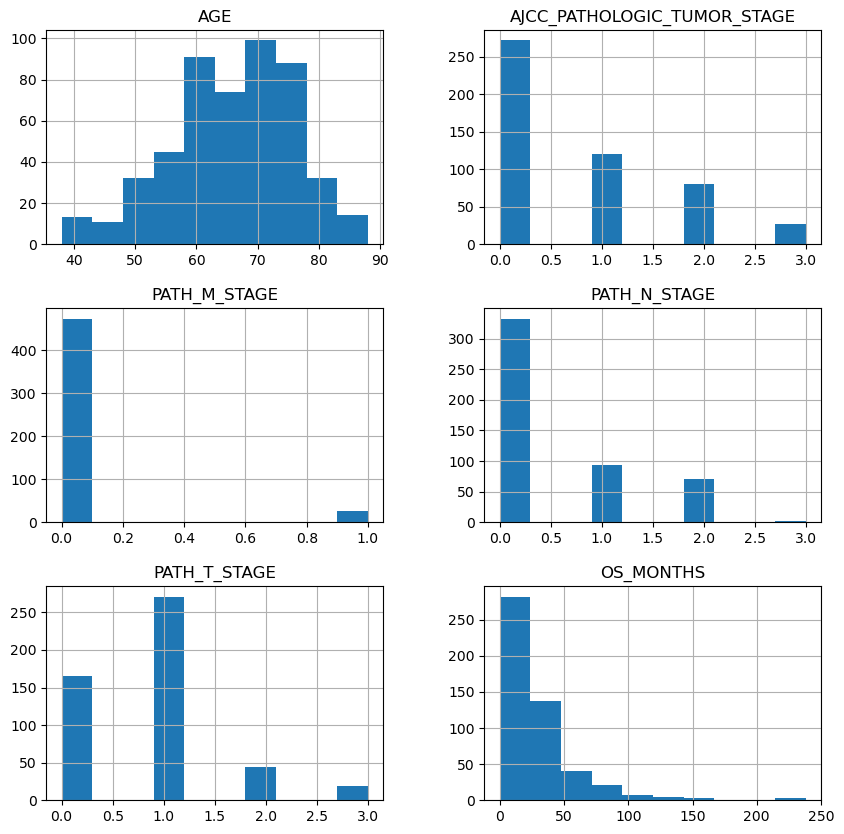

In [259]:
# Numerical data
hists = clinical.hist(figsize=(10,10))
plt.show()

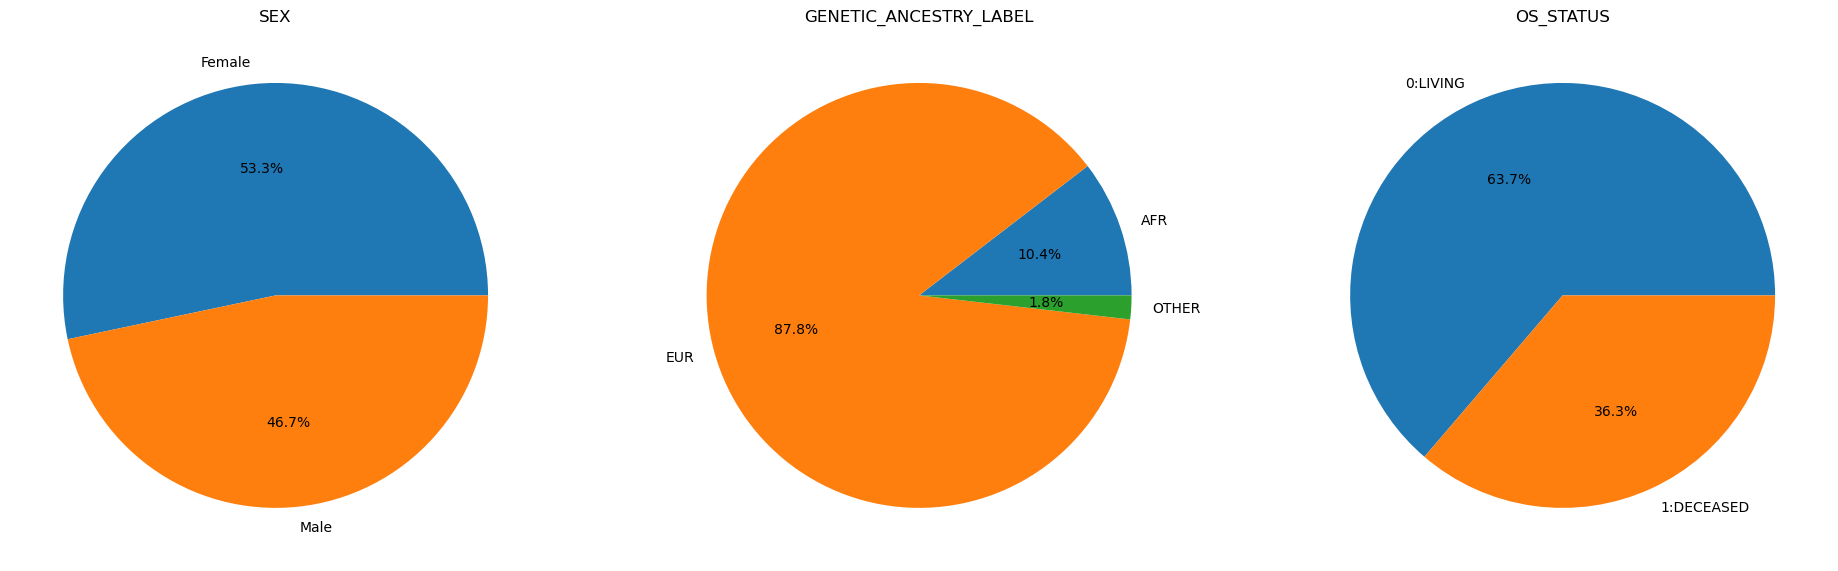

In [254]:
cat_col=["SEX","GENETIC_ANCESTRY_LABEL","OS_STATUS"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), cat_col):
    t = clinical.groupby([column]).size()
    ax.pie(t, labels=t.index.values, autopct='%1.1f%%')
    ax.set_title(column)

plt.show()

In [687]:
np.max(clinical_encoded.AGE)

88.0

## Feature Selection

### Clinical data

In [439]:
def fit_univariate_cox_models(df, time_col, event_col):
    """
    Fits univariate Cox proportional hazards models for each feature in the DataFrame
    and returns a DataFrame with the coefficient and p-value of each feature.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the survival data and features.
    - time_col (str): The column name representing the survival time.
    - event_col (str): The column name representing the event status (1 if event occurred, 0 otherwise).

    Returns:
    - pd.DataFrame: A DataFrame containing features, their coefficients, and p-values.
    """
    # Function to fit Cox model and return coefficient and p-value for a single feature
    def helper_cox(feature):
        cph = CoxPHFitter(penalizer=0.1)
        temp_df = df[[time_col, event_col, feature]]
        cph.fit(temp_df, duration_col=time_col, event_col=event_col)
        coeff = cph.summary.loc[feature, 'coef']
        p_val = cph.summary.loc[feature, 'p']
        return cph.summary.iloc[0, :]

    # Apply the function to all feature columns
    feature_cols = df.drop(columns=[time_col, event_col]).columns
    results = feature_cols.to_series().apply(helper_cox)

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results).reset_index().rename(columns={'index': 'Feature'})

    return results_df


In [441]:
# clinical data
clinical_ft = fit_univariate_cox_models(clinical_encoded, time_col='OS_MONTHS', event_col='OS_STATUS_1:DECEASED')
print(clinical_ft)

                        Feature      coef  exp(coef)  se(coef)  \
0                           AGE  0.002962   1.002966  0.006802   
1   AJCC_PATHOLOGIC_TUMOR_STAGE  0.422772   1.526187  0.065727   
2                  PATH_M_STAGE  0.656862   1.928730  0.260594   
3                  PATH_N_STAGE  0.442788   1.557042  0.080627   
4                  PATH_T_STAGE  0.340981   1.406326  0.086905   
5                      SEX_Male  0.036125   1.036786  0.132057   
6    GENETIC_ANCESTRY_LABEL_EUR  0.134899   1.144421  0.206043   
7  GENETIC_ANCESTRY_LABEL_OTHER -0.166191   0.846885  0.576903   

   coef lower 95%  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
0       -0.010371        0.016294             0.989683             1.016428   
1        0.293949        0.551595             1.341715             1.736020   
2        0.146108        1.167616             1.157321             3.214320   
3        0.284761        0.600814             1.329445             1.823603   
4        0

In [445]:
#Export
clinical_ft.to_csv('Clinical Feature Selection.csv', index=False) 

### Gene expression data

In [272]:
# Add survival data to rna seq dataframe
rnaseq.insert(1, 'OS_MONTHS', clinical_encoded['OS_MONTHS'])
rnaseq.insert(1, 'OS_STATUS_1:DECEASED', clinical_encoded['OS_STATUS_1:DECEASED'])

In [442]:
# Feature selection of Gene expression data
rnaseq_ft = fit_univariate_cox_models(rnaseq, time_col='OS_MONTHS', event_col='OS_STATUS_1:DECEASED')

In [444]:
#Export
rnaseq_ft.to_csv('RNAseq Feature Selection.csv', index=False) 

In [554]:
#Sort features based on p-values and select significant genes
rnaseq_ft=rnaseq_ft.sort_values('p')
order_rnaseq=np.array(rnaseq_ft[rnaseq_ft.p<0.05].Hugo_Symbol)

#Sort rnaseq genes by p-values
rnaseq_filtered = rnaseq[order_rnaseq]

#Filter lowly expressed genes (mean count <15)
rnaseq_filtered=rnaseq_filtered.loc[:,(rnaseq_filtered.mean()>4)]

#Select top 50 genes
rnaseq_filtered=rnaseq_filtered.iloc[:,0:50]
rnaseq_filtered.head()

Hugo_Symbol,FAM117A,DKK1,GNPNAT1,PLEKHB1,BZRAP1,INPP5J,MYLIP,ESYT3,ANLN,IRX5,...,CXCL17,C3orf18,PLK1,PPP1R13B,BTN2A2,FKBP4,ZFP3,KLHDC8B,VDAC1,IVD
TCGA-86-8056,8.938168,8.436299,9.116235,8.678776,9.170153,7.245096,9.251946,8.395324,7.875577,6.814474,...,10.935452,7.433243,5.945493,9.591491,8.840152,9.095371,8.064791,9.182248,10.662935,10.925977
TCGA-64-5781,7.627789,11.972624,11.068960,7.010936,5.747739,6.690012,8.536900,5.283259,10.342908,3.226524,...,7.101545,6.000507,8.887735,7.580100,8.175440,11.037519,5.078840,7.900517,11.910114,10.340763
TCGA-69-7765,9.498295,2.856428,10.113404,9.146042,7.175634,5.853097,10.221442,7.736300,10.225219,8.523723,...,11.798290,7.092292,8.346930,9.401746,8.753925,11.209478,7.635740,8.743458,11.372560,9.860837
TCGA-67-3772,8.614408,6.298574,10.519862,9.175542,6.848398,6.437531,9.190647,7.249986,7.553038,8.179202,...,14.181727,7.280715,7.531296,9.280277,9.258385,10.331947,6.298574,8.411172,11.399977,10.339783
TCGA-53-7626,9.332959,3.955266,9.697716,9.038848,8.493347,6.766065,10.198101,8.650747,8.964376,8.569878,...,12.703845,6.696536,8.048585,10.495185,9.040408,10.578080,7.340286,9.055147,11.027574,10.399353


In [556]:
#Export
rnaseq_filtered.to_csv('RNAseq Filtered.csv', index=True) 

### Methylation data

In [388]:
# Add survival data to rna seq dataframe
met_imputed.insert(0, 'OS_MONTHS', clinical_encoded['OS_MONTHS'])
met_imputed.insert(0, 'OS_STATUS_1:DECEASED', clinical_encoded['OS_STATUS_1:DECEASED'])

In [448]:
# Feature selection of Gene expression data
met_ft = fit_univariate_cox_models(met_imputed, time_col='OS_MONTHS', event_col='OS_STATUS_1:DECEASED')

/Users/bxt231/env_tf/lib/python3.8/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['MAP3K9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/bxt231/env_tf/lib/python3.8/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['NAT9;TMEM104'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/bxt231/env_tf/lib/python3.8/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['MXD4'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try d

In [449]:
#Export
met_ft.to_csv('Methylation Feature Selection.csv', index=False) 

In [557]:
#Sort features based on p-values and select significant genes
met_ft=met_ft.sort_values('p')
order_met=np.array(met_ft[met_ft.p<0.05].NAME)

#Sort rnaseq genes by p-values
met_filtered = met_imputed[order_met]

#Select top 50 genes
met_filtered=met_filtered.iloc[:,0:50]
met_filtered.head()

NAME,RBP5;CLSTN3,CLSTN3,TM4SF19,IVD,METTL7A,MT1E,ADAMTSL2,C12orf76,B4GALT1,ARL14,...,BATF,GATA2,B3GNT8,ZSCAN18,ASAM,GPR135,SNORD64;PAR5,PCYT2;SIRT7,ARHGEF2,IL20RB
TCGA-86-8056,0.047065,0.078896,0.757850,0.078842,0.148458,0.048049,0.071855,0.929494,0.359329,0.654508,...,0.164653,0.510541,0.111421,0.045431,0.528867,0.001686,0.707810,0.804846,0.089256,0.905588
TCGA-69-7765,0.077842,0.076704,0.618624,0.055024,0.166068,0.068332,0.259579,0.898384,0.290677,0.728386,...,0.227292,0.328288,0.157205,0.326131,0.592871,0.016542,0.836247,0.747012,0.083159,0.899507
TCGA-64-5781,0.078874,0.059759,0.478855,0.077074,0.427550,0.141917,0.355319,0.903544,0.573122,0.460962,...,0.389079,0.424186,0.456588,0.226901,0.590139,0.134105,0.555565,0.714150,0.092796,0.645892
TCGA-67-3772,0.044749,0.046669,0.724678,0.040884,0.090269,0.069366,0.063271,0.929128,0.357686,0.652669,...,0.171294,0.323653,0.104977,0.056381,0.579930,0.021643,0.717965,0.588311,0.056274,0.898300
TCGA-53-7626,0.070522,0.058756,0.747632,0.069495,0.194435,0.068266,0.089465,0.903538,0.414848,0.792117,...,0.207897,0.103692,0.155016,0.086540,0.586488,0.016346,0.837196,0.852893,0.063533,0.909905


In [558]:
#Export
met_filtered.to_csv('Methylation Filtered.csv', index=True) 

### Mutation data

In [401]:
# Add survival data to rna seq dataframe
mut.insert(0, 'OS_MONTHS', clinical_encoded['OS_MONTHS'])
mut.insert(0, 'OS_STATUS_1:DECEASED', clinical_encoded['OS_STATUS_1:DECEASED'])

In [446]:
# Feature selection of Gene expression data
mut_ft = fit_univariate_cox_models(mut, time_col='OS_MONTHS', event_col='OS_STATUS_1:DECEASED')

In [447]:
#Export
mut_ft.to_csv('Mutation Feature Selection.csv', index=False) 

In [561]:
#Sort features based on p-values and select significant genes
mut_ft=mut_ft.sort_values('p')
order_mut=np.array(mut_ft[mut_ft.p<0.05].Hugo_Symbol)

#Sort rnaseq genes by p-values
mut_filtered = mut[order_mut]

#Select top 50 genes
mut_filtered=mut_filtered.iloc[:,0:50]
mut_filtered.head()

Hugo_Symbol,ATG4D,SLC7A2,PNCK,LARS,INA,ASB2,CTNNA1,NOM1,ZNF623,IGHV3-66,...,ALS2CL,AXIN2,DNAJA2,IL12B,ESRP2,CRYGN,KCNAB1,CCL7,AGAP3,BANP
TCGA-86-8056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-64-5781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-69-7765,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-67-3772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7626,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [570]:
#Export
mut_filtered.to_csv('Mutation Filtered.csv', index=True)

## Individual DeepSurv models

### Split training and testing data

Stratify split the dataset into training and tesing set (80:20).

In [67]:
# Import data
clinical_encoded=pd.read_csv('Clinical_Processed.csv',index_col=0)
rnaseq_filtered=pd.read_csv('RNAseq Filtered.csv',index_col=0)
met_filtered=pd.read_csv('Methylation Filtered.csv',index_col=0)
mut_filtered=pd.read_csv('Mutation Filtered.csv',index_col=0)

# Stratify split 80:20
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.20, random_state=1)
train_index, test_index = next(splitter.split(clinical_encoded, clinical_encoded['OS_STATUS_1:DECEASED']))

#Clinical data
clinical_train = clinical_encoded.iloc[train_index]
clinical_test = clinical_encoded.iloc[test_index]

X_clinical_train = np.array(clinical_train.drop(columns=["OS_STATUS_1:DECEASED","OS_MONTHS"]))
E_train = np.array(clinical_train["OS_STATUS_1:DECEASED"])
Y_train = np.array(clinical_train["OS_MONTHS"])

X_clinical_test = np.array(clinical_test.drop(columns=["OS_STATUS_1:DECEASED","OS_MONTHS"]))
E_test = np.array(clinical_test["OS_STATUS_1:DECEASED"])
Y_test = np.array(clinical_test["OS_MONTHS"])

#Sort the data by survival months
sort_idx = np.argsort(Y_train)[::-1]
X_clinical_train = X_clinical_train[sort_idx]
Y_train = Y_train[sort_idx]
E_train = E_train[sort_idx]

sort_idx_test = np.argsort(Y_test)[::-1]
X_clinical_test = X_clinical_test[sort_idx_test]
Y_test = Y_test[sort_idx_test]
E_test = E_test[sort_idx_test]

#RNAseq
X_rnaseq_train = np.array(rnaseq_filtered.iloc[train_index])
X_rnaseq_train = X_rnaseq_train[sort_idx]
X_rnaseq_test = np.array(rnaseq_filtered.iloc[test_index])
X_rnaseq_test = X_rnaseq_test[sort_idx_test]

#Methylation
X_met_train = np.array(met_filtered.iloc[train_index])
X_met_train = X_met_train[sort_idx]
X_met_test = np.array(met_filtered.iloc[test_index])
X_met_test = X_met_test[sort_idx_test]

#Mutation
X_mut_train = np.array(mut_filtered.iloc[train_index])
X_mut_train = X_mut_train[sort_idx]
X_mut_test = np.array(mut_filtered.iloc[test_index])
X_mut_test = X_mut_test[sort_idx_test]

### Define helper funtions


In [682]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Normalization, ActivityRegularization
from tensorflow.keras.optimizers.legacy import Nadam
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import clone_model
import itertools

# Define loss function
def negative_log_likelihood(E,y_true, y_pred):
    hazard_ratio = tf.math.exp(y_pred)        
    log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
    uncensored_likelihood = tf.transpose(y_pred) - log_risk
    censored_likelihood = uncensored_likelihood * E
    neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)
    num_observed_events = tf.constant(E.sum(), dtype=tf.float32)    
    neg_likelihood = neg_likelihood_ / num_observed_events
    
    return neg_likelihood

#Helper function for k-fold cv
#Random split into k folds
def split_data_indices(arr, k):
    # Get the indices of the array
    indices = np.arange(len(arr))
    # Shuffle the indices randomly
    np.random.shuffle(indices)
    # Split the shuffled indices into k parts
    split_indices = np.array_split(indices, k)
    # Sort each split in ascending order
    sorted_splits = [np.sort(part) for part in split_indices]
    return sorted_splits

#Select all items excluding the selected indices
def exclude_indices(arr, indices_to_exclude):
    # Create a mask that marks which rows to keep (True) or exclude (False)
    mask = np.ones(arr.shape[0], dtype=bool)
    mask[indices_to_exclude] = False
    # Apply the mask to exclude the specified indices
    result = arr[mask]
    return result

# Train model using K-fold CV
def fit_model_k_fold(model, optimizer,k_fold,X_train,y_train,E_train,epochs, early_stop):
    best_val_loss = float('inf')
    wait = 0
    best_weights = None
    train_loss_hist=[]
    val_loss_hist=[]
    for epoch in range(epochs):
        #print(f'Epoch {epoch + 1}/{epochs}')
        split_indices=split_data_indices(y_train,k_fold)
        val_losses=[]
        train_losses=[]
        for index in split_indices:
            # Select the selected fold as validation set
            X_val=X_train[index]
            y_val=y_train[index]
            E_val=E_train[index]
            # Select the remaining data as training
            X_fold=exclude_indices(X_train, index)
            y_fold=np.delete(y_train, index)
            E_fold=np.delete(E_train, index)
            # Training phase
            with tf.GradientTape() as tape:
                predictions = model(X_fold, training=True)
                train_loss = negative_log_likelihood(E_fold, y_fold, predictions)
                train_losses.append(train_loss.numpy()/k_fold)
            
            gradients = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Validation phase
            val_predictions = model(X_val, training=False)
            val_loss = negative_log_likelihood(E_val,y_val, val_predictions)
            val_losses.append(val_loss.numpy())

        # Calculate the mean of fold losses
        train_loss_mean=np.mean(train_losses)
        val_loss_mean=np.mean(val_losses)

        # Add to history file
        train_loss_hist.append(train_loss_mean)
        val_loss_hist.append(val_loss_mean)
        
        # Print losses
        #print(f'Training loss: {train_loss_mean:.4f} | Validation loss: {val_loss_mean:.4f}')

        # Check for early stopping
        if val_loss_mean < best_val_loss:
            best_val_loss = val_loss_mean
            best_weights = model.get_weights()  # Save the best weights
            wait = 0  # Reset wait counter
        else:
            wait += 1
            if wait >= early_stop:
                #print(f'Early stopping triggered. Restoring model weights from epoch {epoch - early_stop + 1}.')
                model.set_weights(best_weights)  # Restore the best weights
                break
    return train_loss_hist,val_loss_hist

# Function to build a DeepSurv model
def Build_model(n_features,n_hidden_layers,n_filters, l2_rate, lr, decay_rate):
    # Create model
    model = Sequential()
    model.add(Normalization())
    model.add(Dense(units=n_features, activation='selu', kernel_initializer='glorot_uniform', input_shape=(n_features,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    for i in range(n_hidden_layers):
        model.add(Dense(units=n_filters, activation='selu', kernel_initializer='glorot_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

    model.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_rate)))
    model.add(ActivityRegularization(l2=l2_rate))
    
    # Define the optimizer
    optimizer = Nadam(learning_rate=lr, decay=decay_rate)
    
    return model,optimizer

# Function for hyperparameter tuning
def model_tuning(X_train,y_train,E_train,X_test,y_test,E_test,k_fold,n_features,n_hidden_layers,n_filters, l2_rate, lr, decay_rate, epoch,early_stop):
    model_list=[]
    train_loss=[]
    val_loss=[]
    c_index_test=[]
    #Combination of hyperparameters
    hyperparam=list(itertools.product(*[n_hidden_layers,n_filters,l2_rate,lr,decay_rate]))
    #Loop through the combinations to build and train model
    for params in hyperparam:
        print(f'Hyperparameters: hidden layers = {params[0]}, filters = {params[1]}, l2 = {params[2]}, lr = {params[3]}, decay = {params[4]}')
        #Build model
        model,optimizer=Build_model(n_features,params[0],params[1], params[2], params[3], params[4])
        #Train k-fold cross-validation
        train_loss_hist,val_loss_hist=fit_model_k_fold(model, optimizer,k_fold,X_train,y_train,E_train,epoch, early_stop)
        #Clone model
        model_copy = clone_model(model)
        model_copy.set_weights(model.get_weights())
        #Add to list of models
        model_list.append(model_copy)
        #Add train and val loss
        train_loss.append(train_loss_hist)
        val_loss.append(val_loss_hist)
        #Find c_index for test data
        Y_pred = np.exp(-model.predict(X_test))
        c_index_test.append(concordance_index(y_test, Y_pred, E_test))

    #Select the model with highest test c-index
    best_index=np.argmax(c_index_test)
    cols=['layers','filters','l2','lr','decay']
    best_param= {cols[i] : hyperparam[best_index][i] for i in range(5)}
    best_model= model_list[best_index]
    best_train_loss=train_loss[best_index]
    best_val_loss=val_loss[best_index]
    
    #Make summary dataframe
    summary_res=pd.DataFrame(hyperparam, columns=cols)
    summary_res['c-index']=c_index_test
    summary_res['train loss']=train_loss
    summary_res['val loss']=val_loss
    
    return best_model,best_param,best_train_loss,best_val_loss,summary_res

# Function to perform bootstrap resampling
def bootstrap_accuracy(Y_pred, Y, E, n_bootstrap=100):
    c_indices = []
    n_samples = len(Y_pred)
    # Get predictions
    Y_pred = np.exp(-Y_pred)

    for _ in range(n_bootstrap):
        # Create a bootstrap sample (sampling with replacement)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_sample = Y[indices]
        E_sample = E[indices]
        
        # Get matched predictions
        Y_pred_sample = Y_pred[indices]
        
        # Calculate accuracy
        c_index = concordance_index(y_sample, Y_pred_sample, E_sample)
        c_indices.append(c_index)

    # Calculate mean and ci
    mean_c_index = np.mean(c_indices)
    ci_c_index = (np.percentile(c_indices, 2.5), np.percentile(c_indices, 97.5))
    print(f"Mean C-index: {mean_c_index:.4f}")
    print(f"95% CI C-index: {ci_c_index}")
        
    return c_indices, mean_c_index, ci_c_index


# Function to find Kaplan Meier Curve
def KM_risk(Y_pred, Y, E, out_file):
    # Predict risk score of test patients
    risk=np.squeeze(np.exp(Y_pred))
    med_risk = np.median(risk)
    # Split the indices into two groups based on the median
    low_risk_indices = [i for i, x in enumerate(risk) if x <= med_risk]
    high_risk_indices = [i for i, x in enumerate(risk) if x > med_risk]
    
    # Create a KaplanMeierFitter object
    kmf = KaplanMeierFitter()
    
    # Fit the model for each group
    kmf.fit(Y[low_risk_indices], 
            E[low_risk_indices], 
            label="Low risk")
    kmf.plot_survival_function(ci_show=False)
    
    kmf.fit(Y[high_risk_indices], 
            E[high_risk_indices], 
            label="High risk")
    kmf.plot_survival_function(ci_show=False)
    
    # Calculate log rank test p value
    log_rank = logrank_test(Y[low_risk_indices],Y[high_risk_indices],E[low_risk_indices],E[high_risk_indices])

    # Add labels and title
    plt.text(80, 0.8, f'p-value = {log_rank.p_value:.3}', fontsize = 12)
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.title('Kaplan-Meier Curves')
    # Saving the figure
    plt.savefig(out_file+".jpg", dpi=300)
    plt.show()

### Clinical DeepSurv model

#### Training Model

In [417]:
# Hyperparameter tuning and training
model_clinical,best_param_clinical,train_loss_clinical,val_loss_clinical,hp_clinical=model_tuning(X_clinical_train,Y_train,E_train,X_clinical_test,Y_test,E_test,k_fold=5,n_features=8,n_hidden_layers=[2,3],n_filters=[32], l2_rate=[0.1,0.01,0.001], lr=[0.01,0.001], decay_rate=[0.001], epoch=500,early_stop=50)


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 18ms/step


2024-11-17 09:37:13.126360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 8ms/step


2024-11-17 09:38:45.527976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 09:39:15.559051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 16ms/step


2024-11-17 09:40:18.646641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 10ms/step


2024-11-17 09:40:42.500732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 09:41:51.265596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 09:42:27.991742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 09:43:31.629272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 09:43:57.810329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 09:44:54.963731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 17ms/step


2024-11-17 09:45:23.787312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 25ms/step


2024-11-17 09:46:41.557684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [503]:
# Display the tuning dataframe
print(best_param_clinical)

{'layers': 2, 'filters': 32, 'l2': 0.1, 'lr': 0.001, 'decay': 0.001}


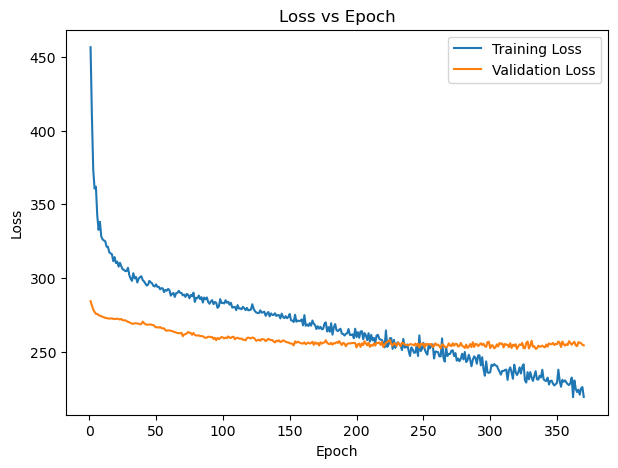

In [459]:
#Plot loss vs epoch
epoch_=list(range(1,len(train_loss_clinical)+1))
plt.figure(figsize=(7, 5))
plt.plot(epoch_,train_loss_clinical, label="Training Loss")
plt.plot(epoch_,val_loss_clinical, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Saving the figure.
plt.savefig("Clinical DeepSurv.jpg", dpi=300)
plt.show()

#### Evaluation

In [567]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_clinical=model_clinical.predict(X_clinical_train)
c_index_train_clinical,mean_c_index_train_clinical,ci_c_index_train_clinical=bootstrap_accuracy(Y_pred_train_clinical,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_clinical=model_clinical.predict(X_clinical_test)
c_index_test_clinical,mean_c_index_test_clinical,ci_c_index_test_clinical=bootstrap_accuracy(Y_pred_test_clinical,Y_test,E_test,100)

Train set
13/13 [==============================] - 0s 5ms/step
Mean C-index: 0.7118
95% CI C-index: (0.6659237001498071, 0.7572364285503939)
Test set
4/4 [==============================] - 0s 12ms/step
Mean C-index: 0.6712
95% CI C-index: (0.5786726531670449, 0.7620392834662553)


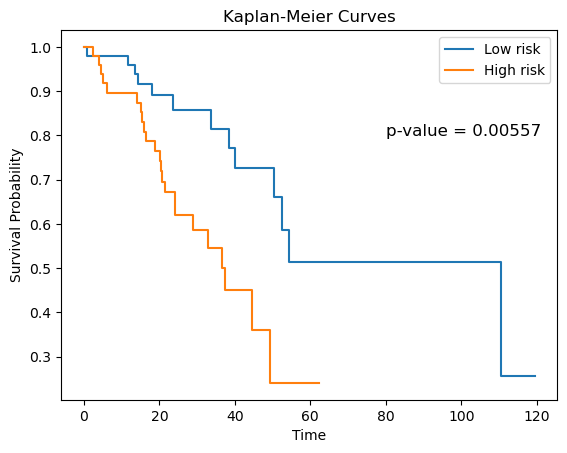

In [568]:
# Kaplan Meier Curve of test data
KM_risk(Y_pred_test_clinical, Y_test, E_test, "Clinical KM")

### RNAseq DeepSurv Model
#### Training Model

In [460]:
# Hyperparameter tuning and training
model_rnaseq,best_param_rnaseq,train_loss_rnaseq,val_loss_rnaseq,hp_rnaseq=model_tuning(X_rnaseq_train,Y_train,E_train,X_rnaseq_test,Y_test,E_test,k_fold=5,n_features=50,n_hidden_layers=[2,3],n_filters=[32,64], l2_rate=[0.1,0.01,0.001], lr=[0.01,0.001], decay_rate=[0.001], epoch=500,early_stop=50)


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001


2024-11-17 10:23:29.541489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 43ms/step
Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 10:24:28.896923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 20ms/step
Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 10:24:43.791464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 27ms/step
Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001


2024-11-17 10:25:46.276710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 20ms/step
Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 10:26:02.838438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001


2024-11-17 10:26:48.669526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 14ms/step
Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.1, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 10:27:04.377275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step
Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 24ms/step


2024-11-17 10:28:07.402748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.01, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 10:28:22.640565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 15ms/step
Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.01, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 10:29:15.229255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 14ms/step
Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 10:29:31.309989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 10:30:13.635772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 10:30:33.172272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 24ms/step


2024-11-17 10:31:58.422268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 10:32:16.760385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 10:34:02.113792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:34:23.004320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 10:35:52.871713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:36:10.433077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 10:37:08.017528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:37:28.816000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 21ms/step


2024-11-17 10:38:37.462096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 10:38:56.748459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 10:39:56.453823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [502]:
# Display the tuning dataframe
print(best_param_rnaseq)

{'layers': 3, 'filters': 32, 'l2': 0.001, 'lr': 0.001, 'decay': 0.001}


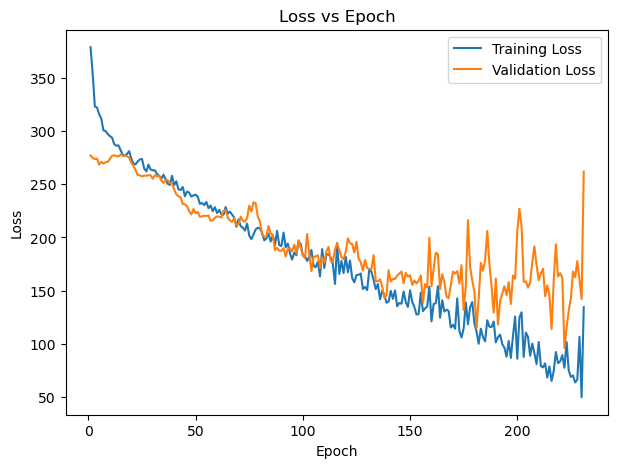

In [462]:
#Plot loss vs epoch
epoch_=list(range(1,len(train_loss_rnaseq)+1))
plt.figure(figsize=(7, 5))
plt.plot(epoch_,train_loss_rnaseq, label="Training Loss")
plt.plot(epoch_,val_loss_rnaseq, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Saving the figure.
plt.savefig("RNAseq DeepSurv.jpg", dpi=300)
plt.show()

#### Evaluation

In [569]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_rnaseq=model_rnaseq.predict(X_rnaseq_train)
c_index_train_rnaseq,mean_c_index_train_rnaseq,ci_c_index_train_rnaseq=bootstrap_accuracy(Y_pred_train_rnaseq,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_rnaseq=model_rnaseq.predict(X_rnaseq_test)
c_index_test_rnaseq,mean_c_index_test_rnaseq,ci_c_index_test_rnaseq=bootstrap_accuracy(Y_pred_test_rnaseq,Y_test,E_test,100)

Train set
13/13 [==============================] - 1s 19ms/step
Mean C-index: 0.9205
95% CI C-index: (0.8998317535930561, 0.9355580793937419)
Test set
4/4 [==============================] - 1s 86ms/step
Mean C-index: 0.7050
95% CI C-index: (0.5805486935866983, 0.797981773354503)


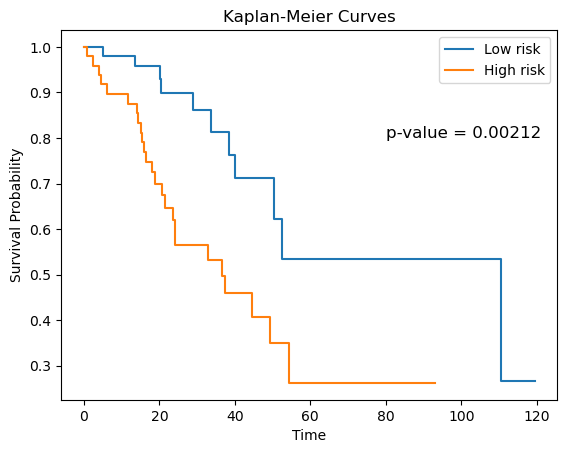

In [570]:
# Kaplan Meier Curve of test data
KM_risk(Y_pred_test_rnaseq, Y_test, E_test, "RNAseq KM")

### Methylation DeepSurv
#### Training Model

In [466]:
# Hyperparameter tuning and training
model_met,best_param_met,train_loss_met,val_loss_met,hp_met=model_tuning(X_met_train,Y_train,E_train,X_met_test,Y_test,E_test,k_fold=5,n_features=50,n_hidden_layers=[2,3],n_filters=[32,64], l2_rate=[0.1,0.01,0.001], lr=[0.01,0.001], decay_rate=[0.001], epoch=500,early_stop=30)


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 10:47:34.836897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 10:48:35.667375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 8ms/step


2024-11-17 10:48:51.133847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:50:04.030485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 10ms/step


2024-11-17 10:50:20.503453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 9ms/step


2024-11-17 10:51:23.378163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 10:51:37.880894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 9ms/step


2024-11-17 10:52:22.545948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:52:38.411246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 8ms/step


2024-11-17 10:53:20.292009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 10:53:37.134474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 10ms/step


2024-11-17 10:54:36.973099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:54:51.408698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 10:56:05.478201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 9ms/step


2024-11-17 10:56:21.088430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 10:57:25.020672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 16ms/step


2024-11-17 10:57:45.909035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001


2024-11-17 10:58:58.260292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 25ms/step
Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 18ms/step


2024-11-17 10:59:18.069220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 10:59:59.444689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:00:16.575686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.01, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 11:01:14.356813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 50ms/step
Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.001, lr = 0.01, decay = 0.001


2024-11-17 11:01:30.349065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step
Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:02:15.431037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [467]:
# Display the tuning dataframe
print(best_param_met)

{'layers': 3, 'filters': 64, 'l2': 0.01, 'lr': 0.001, 'decay': 0.001}


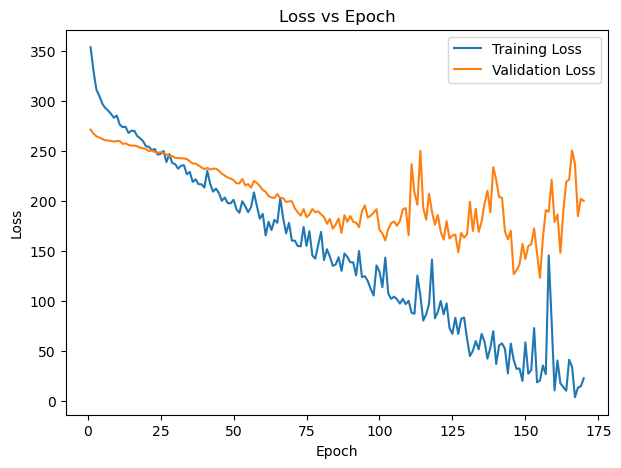

In [468]:
#Plot loss vs epoch
epoch_=list(range(1,len(train_loss_met)+1))
plt.figure(figsize=(7, 5))
plt.plot(epoch_,train_loss_met, label="Training Loss")
plt.plot(epoch_,val_loss_met, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Saving the figure.
plt.savefig("Methylation DeepSurv.jpg", dpi=300)
plt.show()

#### Evaluation

In [571]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_met=model_met.predict(X_met_train)
c_index_train_met,mean_c_index_train_met,ci_c_index_train_met=bootstrap_accuracy(Y_pred_train_met,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_met=model_met.predict(X_met_test)
c_index_test_met,mean_c_index_test_met,ci_c_index_test_met=bootstrap_accuracy(Y_pred_test_met,Y_test,E_test,100)

Train set
13/13 [==============================] - 1s 28ms/step
Mean C-index: 0.9202
95% CI C-index: (0.898611743946708, 0.9365560158965547)
Test set
4/4 [==============================] - 1s 60ms/step
Mean C-index: 0.6784
95% CI C-index: (0.5929618968136964, 0.7765843639974721)


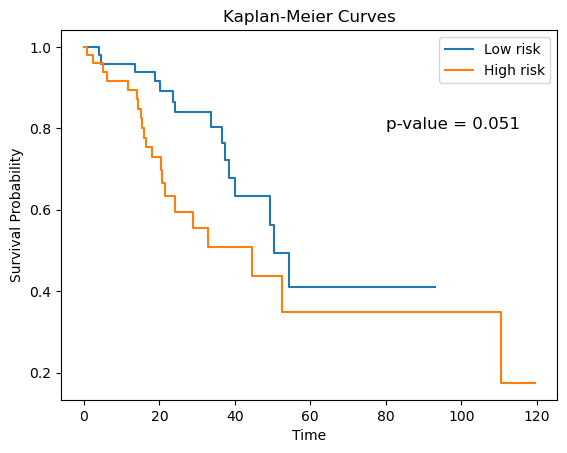

In [572]:
# Kaplan Meier Curve of test data
KM_risk(Y_pred_test_met, Y_test, E_test, "Methylation KM")

### Mutation DeepSurv
#### Training Model

In [472]:
# Hyperparameter tuning and training
model_mut,best_param_mut,train_loss_mut,val_loss_mut,hp_mut=model_tuning(X_mut_train,Y_train,E_train,X_mut_test,Y_test,E_test,k_fold=5,n_features=50,n_hidden_layers=[2,3],n_filters=[32,64], l2_rate=[0.1,0.01,0.001], lr=[0.01,0.001], decay_rate=[0.001], epoch=500,early_stop=30)


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 9ms/step


2024-11-17 11:03:51.288427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 11:04:34.073349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 10ms/step


2024-11-17 11:04:58.087164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:05:39.787091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:06:02.897960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:06:40.666959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:06:58.631742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:07:33.940515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 9ms/step


2024-11-17 11:07:49.952193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:08:29.020467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 11:08:43.749939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 64, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 11:09:20.056791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:09:42.961886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 21ms/step


2024-11-17 11:10:28.121603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:10:53.788689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 15ms/step


2024-11-17 11:11:38.574083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:12:02.731358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 16ms/step


2024-11-17 11:12:54.104359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 16ms/step


2024-11-17 11:13:11.262508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:13:48.316901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 11:14:08.042565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 17ms/step


2024-11-17 11:14:50.239352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 17ms/step


2024-11-17 11:15:05.788712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 64, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 19ms/step


2024-11-17 11:15:42.972042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [473]:
# Display the tuning dataframe
print(best_param_mut)

{'layers': 2, 'filters': 64, 'l2': 0.1, 'lr': 0.01, 'decay': 0.001}


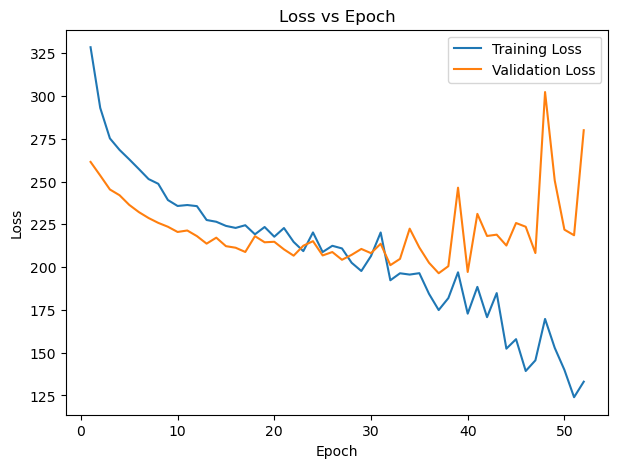

In [474]:
#Plot loss vs epoch
epoch_=list(range(1,len(train_loss_mut)+1))
plt.figure(figsize=(7, 5))
plt.plot(epoch_,train_loss_mut, label="Training Loss")
plt.plot(epoch_,val_loss_mut, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Saving the figure.
plt.savefig("Mutation DeepSurv.jpg", dpi=300)
plt.show()

#### Evaluation

In [573]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_mut=model_mut.predict(X_mut_train)
c_index_train_mut,mean_c_index_train_mut,ci_c_index_train_mut=bootstrap_accuracy(Y_pred_train_mut,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_mut=model_mut.predict(X_mut_test)
c_index_test_mut,mean_c_index_test_mut,ci_c_index_test_mut=bootstrap_accuracy(Y_pred_test_mut,Y_test,E_test,100)

Train set
13/13 [==============================] - 0s 14ms/step
Mean C-index: 0.8107
95% CI C-index: (0.7771779520050618, 0.8472090534929916)
Test set
4/4 [==============================] - 0s 37ms/step
Mean C-index: 0.7365
95% CI C-index: (0.6654153179019873, 0.8165130186141882)


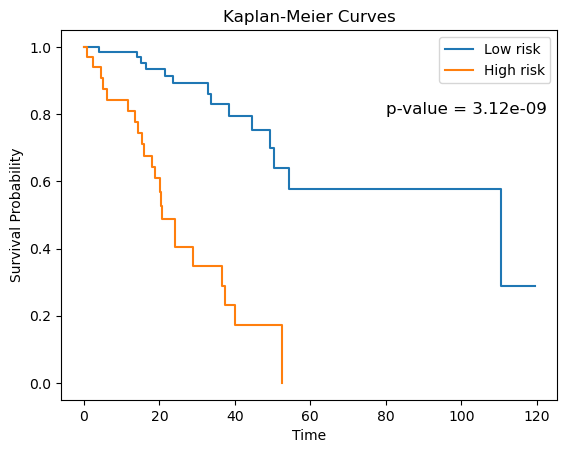

In [574]:
# Kaplan Meier Curve
KM_risk(Y_pred_test_mut, Y_test, E_test, "Mutation KM")

## Ensemble Models
### Average ensemble


In [539]:
# Average emsemble function
def avg_ensemble(X_clinical, X_rnaseq, X_met, X_mut):
    pred_clincal = model_clinical.predict(X_clinical)
    pred_rnaseq = model_rnaseq.predict(X_rnaseq)
    pred_met = model_met.predict(X_met)
    pred_mut = model_mut.predict(X_mut)
    pred_concat = np.concatenate((pred_clincal, pred_rnaseq, pred_met, pred_mut), axis=1)
    pred_avg = np.mean(pred_concat, axis=1)
    return pred_avg

In [575]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_avg=avg_ensemble(X_clinical_train, X_rnaseq_train, X_met_train, X_mut_train)
c_index_train_avg,mean_c_index_train_avg,ci_c_index_train_avg=bootstrap_accuracy(Y_pred_train_avg,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_avg=avg_ensemble(X_clinical_test, X_rnaseq_test, X_met_test, X_mut_test)
c_index_test_avg,mean_c_index_test_avg,ci_c_index_test_avg=bootstrap_accuracy(Y_pred_test_avg,Y_test,E_test,100)

Train set
13/13 [==============================] - 0s 3ms/step
Mean C-index: 0.9471
95% CI C-index: (0.9350898111520188, 0.9588446986751796)
Test set
4/4 [==============================] - 0s 6ms/step
Mean C-index: 0.7834
95% CI C-index: (0.6911976726990584, 0.8534739307701261)


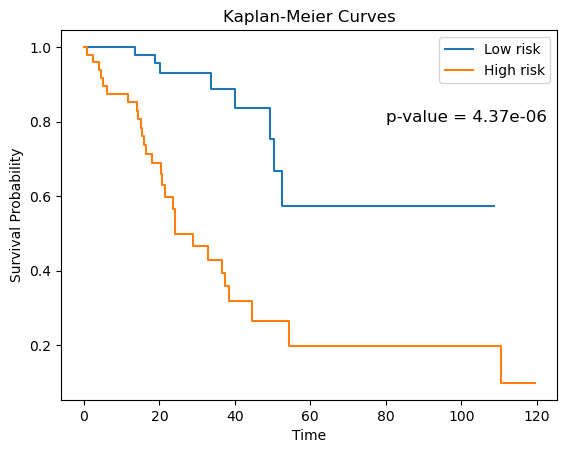

In [576]:
# Kaplan Meier Curve
KM_risk(Y_pred_test_avg, Y_test, E_test, "Average Ensemble KM")

### Weighted average

In [596]:
# Weighted average emsemble based on mean c-index function
def w_avg_ensemble(X_clinical, X_rnaseq, X_met, X_mut, weights):
    pred_clincal = model_clinical.predict(X_clinical)
    pred_rnaseq = model_rnaseq.predict(X_rnaseq)
    pred_met = model_met.predict(X_met)
    pred_mut = model_mut.predict(X_mut)
    pred_concat = np.concatenate((pred_clincal, pred_rnaseq, pred_met, pred_mut), axis=1)
    pred_w_avg = np.sum((pred_concat*weights),axis=1)/weights.sum()
    return pred_w_avg

In [601]:
# Define weights as the mean c-index for test data
weights=np.array([mean_c_index_test_clinical,mean_c_index_test_rnaseq,mean_c_index_test_met,mean_c_index_test_mut])

#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_w_avg=w_avg_ensemble(X_clinical_train, X_rnaseq_train, X_met_train, X_mut_train,weights)
c_index_train_w_avg,mean_c_index_train_w_avg,ci_c_index_w_train_avg=bootstrap_accuracy(Y_pred_train_w_avg,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_w_avg=w_avg_ensemble(X_clinical_test, X_rnaseq_test, X_met_test, X_mut_test,weights)
c_index_test_w_avg,mean_c_index_test_w_avg,ci_c_index_test_w_avg=bootstrap_accuracy(Y_pred_test_w_avg,Y_test,E_test,100)

Train set
13/13 [==============================] - 0s 3ms/step
Mean C-index: 0.9479
95% CI C-index: (0.936613260273485, 0.9615614080596007)
Test set
4/4 [==============================] - 0s 3ms/step
Mean C-index: 0.7844
95% CI C-index: (0.7055733706195024, 0.8476250780112335)


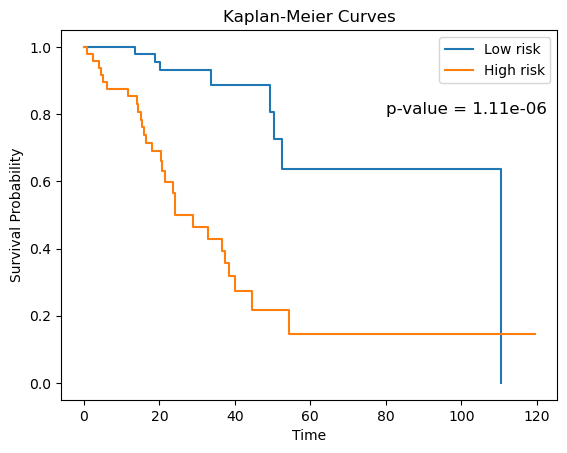

In [602]:
# Kaplan Meier Curve
KM_risk(Y_pred_test_w_avg, Y_test, E_test, "Weighted Average Ensemble KM")

### Stacking model

In [609]:
# Create new train and test sets from individual model prediction
def get_predictions(X_clinical, X_rnaseq, X_met, X_mut):
    pred_clincal = model_clinical.predict(X_clinical)
    pred_rnaseq = model_rnaseq.predict(X_rnaseq)
    pred_met = model_met.predict(X_met)
    pred_mut = model_mut.predict(X_mut)
    pred_concat = np.concatenate((pred_clincal, pred_rnaseq, pred_met, pred_mut), axis=1)
    return pred_concat

X_stacking_train = get_predictions(X_clinical_train, X_rnaseq_train, X_met_train, X_mut_train)
X_stacking_test = get_predictions(X_clinical_test, X_rnaseq_test, X_met_test, X_mut_test)


4/4 [==============================] - 0s 5ms/step


In [610]:
# Build and train meta model
model_meta,best_param_meta,train_loss_meta,val_loss_meta,hp_meta=model_tuning(X_stacking_train,Y_train,E_train,X_stacking_test,Y_test,E_test,k_fold=5,n_features=4,n_hidden_layers=[1,2,3],n_filters=[16,32], l2_rate=[0.1,0.01,0.001], lr=[0.01,0.001], decay_rate=[0.001], epoch=100,early_stop=20)


Hyperparameters: hidden layers = 1, filters = 16, l2 = 0.1, lr = 0.01, decay = 0.001


2024-11-17 13:43:36.814533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 33ms/step
Hyperparameters: hidden layers = 1, filters = 16, l2 = 0.1, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:43:55.601839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 43ms/step
Hyperparameters: hidden layers = 1, filters = 16, l2 = 0.01, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:44:10.003219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 31ms/step
Hyperparameters: hidden layers = 1, filters = 16, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 16ms/step


2024-11-17 13:44:31.401405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 1, filters = 16, l2 = 0.001, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:44:39.199260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 17ms/step
Hyperparameters: hidden layers = 1, filters = 16, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 39ms/step


2024-11-17 13:45:00.908526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 1, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 13:45:19.611386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 1, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:45:41.146375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 69ms/step
Hyperparameters: hidden layers = 1, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:45:55.988126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 9ms/step
Hyperparameters: hidden layers = 1, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 13:46:17.164859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 1, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 13:46:22.252770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 1, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 8ms/step


2024-11-17 13:46:42.590642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 16, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 13:46:54.523958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 16, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 13:47:16.088897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 16, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 12ms/step


2024-11-17 13:47:30.290975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 16, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 11ms/step


2024-11-17 13:47:54.918279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 16, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 9ms/step


2024-11-17 13:48:01.423871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 16, l2 = 0.001, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:48:28.864928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 12ms/step
Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 13:48:44.806007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 13:49:09.471838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 13:49:25.241157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 15ms/step


2024-11-17 13:49:38.816060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 10ms/step


2024-11-17 13:49:51.972167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 2, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 33ms/step


2024-11-17 13:50:16.812877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 16, l2 = 0.1, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 13ms/step


2024-11-17 13:50:34.416429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 16, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 13:51:00.020181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 16, l2 = 0.01, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 13:51:16.733692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 16, l2 = 0.01, lr = 0.001, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:51:40.206567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 31ms/step
Hyperparameters: hidden layers = 3, filters = 16, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 23ms/step


2024-11-17 13:51:57.908815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 16, l2 = 0.001, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 25ms/step


2024-11-17 13:52:32.317233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:52:44.245402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 73ms/step
Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.1, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 24ms/step


2024-11-17 13:53:15.544816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.01, decay = 0.001
1/4 [======>.......................] - ETA: 0s

2024-11-17 13:53:27.535148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 80ms/step
Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.01, lr = 0.001, decay = 0.001
4/4 [==============================] - 0s 26ms/step


2024-11-17 13:53:58.782466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.01, decay = 0.001
4/4 [==============================] - 0s 14ms/step


2024-11-17 13:54:26.378906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Hyperparameters: hidden layers = 3, filters = 32, l2 = 0.001, lr = 0.001, decay = 0.001


2024-11-17 13:54:57.867424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step


In [611]:
# Display the tuning dataframe
print(best_param_meta)

{'layers': 3, 'filters': 32, 'l2': 0.001, 'lr': 0.01, 'decay': 0.001}


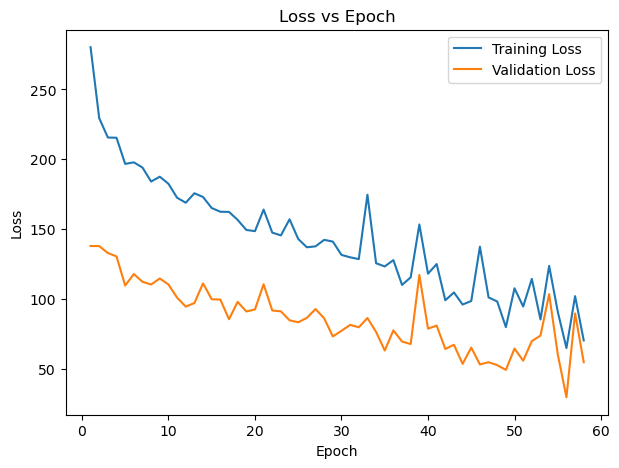

In [612]:
#Plot loss vs epoch
epoch_=list(range(1,len(train_loss_meta)+1))
plt.figure(figsize=(7, 5))
plt.plot(epoch_,train_loss_meta, label="Training Loss")
plt.plot(epoch_,val_loss_meta, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Saving the figure.
plt.savefig("Meta Model DeepSurv.jpg", dpi=300)
plt.show()

#### Evaluation

In [613]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_meta=model_meta.predict(X_stacking_train)
c_index_train_meta,mean_c_index_train_meta,ci_c_index_train_meta=bootstrap_accuracy(Y_pred_train_meta,Y_train,E_train,100)

#Test
print("Test set")
Y_pred_test_meta=model_meta.predict(X_stacking_test)
c_index_test_meta,mean_c_index_test_meta,ci_c_index_test_meta=bootstrap_accuracy(Y_pred_test_meta,Y_test,E_test,100)

Train set
 1/13 [=>............................] - ETA: 3s

2024-11-17 13:55:31.981823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 8ms/step
Mean C-index: 0.9497
95% CI C-index: (0.9348533597795469, 0.9624044489357432)
Test set
4/4 [==============================] - 0s 14ms/step
Mean C-index: 0.7993
95% CI C-index: (0.7313187678043002, 0.8672254925656109)


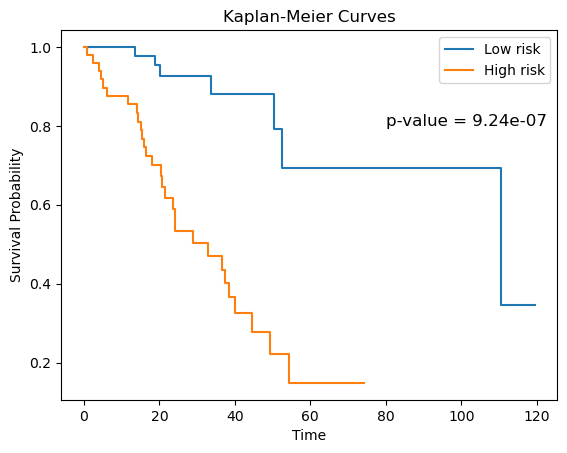

In [614]:
# Kaplan Meier Curve of test data
KM_risk(Y_pred_test_meta, Y_test, E_test, "Meta Model KM")

### Cox multivariate proportional hazard model

In [630]:
# Contruct training and testing data set
df_combined_train=pd.concat([clinical_encoded.iloc[train_index], rnaseq_filtered.iloc[train_index],met_filtered.iloc[train_index],mut_filtered.iloc[train_index]], axis=1)
df_combined_train=df_combined_train.dropna()

df_combined_test=pd.concat([clinical_encoded.iloc[test_index], rnaseq_filtered.iloc[test_index],met_filtered.iloc[test_index],mut_filtered.iloc[test_index]], axis=1)
df_combined_test=df_combined_test.dropna()


In [632]:
# Fit Cox model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_combined_train, duration_col='OS_MONTHS', event_col='OS_STATUS_1:DECEASED')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 397 total observations, 252 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_1:DECEASED'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 397
number of events observed = 145
   partial log-likelihood = -608.09
         time fit was run = 2024-11-17 20:25:54 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
AGE                            0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
AJCC_PATHOLOGIC_TUMOR_STAGE    0.26       1.29       0.13             0.01             0.51                 1.01                 1.66
PATH_M_STAGE                   0.78       2.18       0.43            -0.07             1.63                 0.93                 5.10
PATH_N_STAGE                   0.16       1.17       0.14            -0.11             0.43                 0.89                 1.54
PATH_T_STAGE                   0.02       1.02       0.13            -0.24             0.27                 0.79                 1.31
SEX_Male                      -0.07       0.93       0.19            -0.44             0.30                 0.64                 1.35
GENETIC_ANCESTRY_LABEL_EUR    -0.05       0.95       0.32            -0.68             0.57                 0.51                 1.77
GENETIC_ANCESTRY_LABEL_OTHER  -0.06       0.94       0.76            -1.56             1.43                 0.21                 4.18
FAM117A                       -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.36
DKK1                           0.07       1.07       0.03             0.00             0.14                 1.00                 1.15
GNPNAT1                        0.17       1.19       0.15            -0.12             0.46                 0.89                 1.59
PLEKHB1                        0.01       1.01       0.09            -0.16             0.18                 0.85                 1.19
BZRAP1                         0.05       1.05       0.08            -0.11             0.22                 0.90                 1.24
INPP5J                        -0.03       0.97       0.08            -0.19             0.14                 0.83                 1.15
MYLIP                         -0.11       0.89       0.14            -0.40             0.17                 0.67                 1.19
ESYT3                          0.05       1.05       0.07            -0.09             0.19                 0.92                 1.21
ANLN                          -0.05       0.95       0.09            -0.22             0.12                 0.80                 1.13
IRX5                           0.01       1.01       0.06            -0.11             0.13                 0.90                 1.14
TLE1                           0.24       1.27       0.15            -0.05             0.53                 0.95                 1.70
ANKRD65                       -0.05       0.95       0.07            -0.19             0.09                 0.82                 1.09
LASS4                          0.04       1.04       0.09            -0.14             0.22                 0.87                 1.25
SFTA3                          0.01       1.01       0.06            -0.11             0.13                 0.90                 1.14
SLC47A1                        0.01       1.01       0.06            -0.12             0.13                 0.89                 1.14
LDHA                           0.03       1.03       0.15            -0.26             0.32                 0.77                 1.38
SLC25A42                       0.22       1.25       0.15            -0.07 

In [638]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_cox=np.array(cph.predict_log_partial_hazard(df_combined_train))
c_index_train_cox,mean_c_index_train_cox,ci_c_index_train_cox=bootstrap_accuracy(Y_pred_train_cox,np.array(df_combined_train['OS_MONTHS']),np.array(df_combined_train['OS_STATUS_1:DECEASED']),100)

#Test
print("Test set")
Y_pred_test_cox=np.array(cph.predict_log_partial_hazard(df_combined_test))
c_index_test_cox,mean_c_index_test_cox,ci_c_index_test_cox=bootstrap_accuracy(Y_pred_test_cox,np.array(df_combined_test['OS_MONTHS']),np.array(df_combined_test['OS_STATUS_1:DECEASED']),100)


Train set
Mean C-index: 0.8783
95% CI C-index: (0.8496127782196977, 0.9019662853519864)
Test set
Mean C-index: 0.7348
95% CI C-index: (0.6657458973095943, 0.7995862072443185)


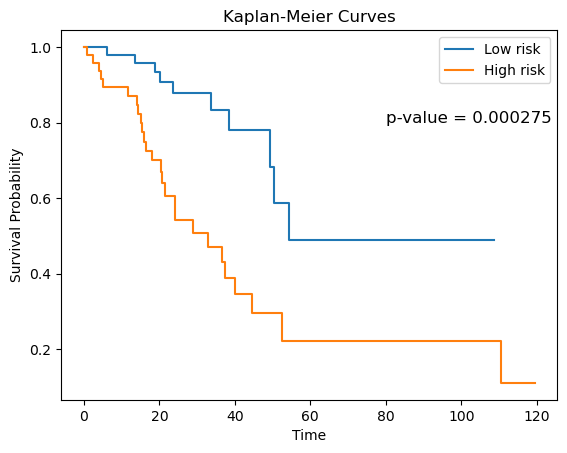

In [640]:
# Kaplan Meier Curve of test data
KM_risk(Y_pred_test_cox,np.array(df_combined_test['OS_MONTHS']),np.array(df_combined_test['OS_STATUS_1:DECEASED']), "Cox Model KM")

### Random Survival Forest

In [651]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# Contruct training and testing data set
X_train_RF=df_combined_train.drop(['OS_STATUS_1:DECEASED','OS_MONTHS'], axis=1, inplace=False)
Y_train_RF=Surv.from_dataframe('OS_STATUS_1:DECEASED','OS_MONTHS',df_combined_train)

X_test_RF=df_combined_test.drop(['OS_STATUS_1:DECEASED','OS_MONTHS'], axis=1, inplace=False)
Y_test_RF=Surv.from_dataframe('OS_STATUS_1:DECEASED','OS_MONTHS',df_combined_test)

In [664]:
# Fit the Random survival forest
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=20, min_samples_leaf=15, random_state=21)
rsf.fit(X_train_RF, Y_train_RF)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=20, random_state=21)

In [665]:
#Boostrap c-index for train and test set
# Train
print("Train set")
Y_pred_train_rf=rsf.predict(X_train_RF)
c_index_train_rf,mean_c_index_train_rf,ci_c_index_train_rf=bootstrap_accuracy(Y_pred_train_rf,np.array(df_combined_train['OS_MONTHS']),np.array(df_combined_train['OS_STATUS_1:DECEASED']),100)

#Test
print("Test set")
Y_pred_test_rf=rsf.predict(X_test_RF)
c_index_test_rf,mean_c_index_test_rf,ci_c_index_test_rf=bootstrap_accuracy(Y_pred_test_rf,np.array(df_combined_test['OS_MONTHS']),np.array(df_combined_test['OS_STATUS_1:DECEASED']),100)


Train set
Mean C-index: 0.8486
95% CI C-index: (0.8209380279208115, 0.8812676186506947)
Test set
Mean C-index: 0.7063
95% CI C-index: (0.6269622781556757, 0.7776709475457138)


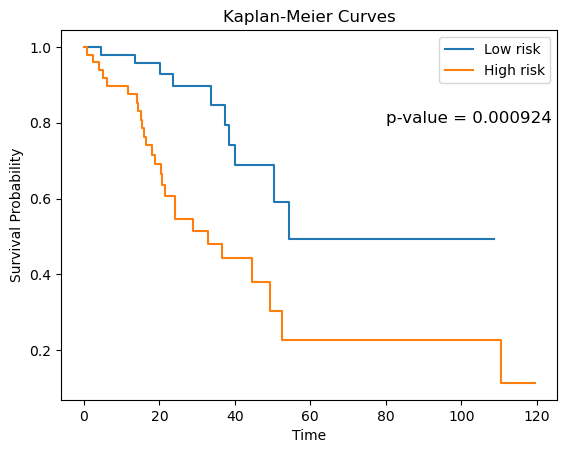

In [666]:
# Kaplan Meier Curve of test data
KM_risk(Y_pred_test_rf,np.array(df_combined_test['OS_MONTHS']),np.array(df_combined_test['OS_STATUS_1:DECEASED']), "Random Survival Forest KM")

## Comparing model performance

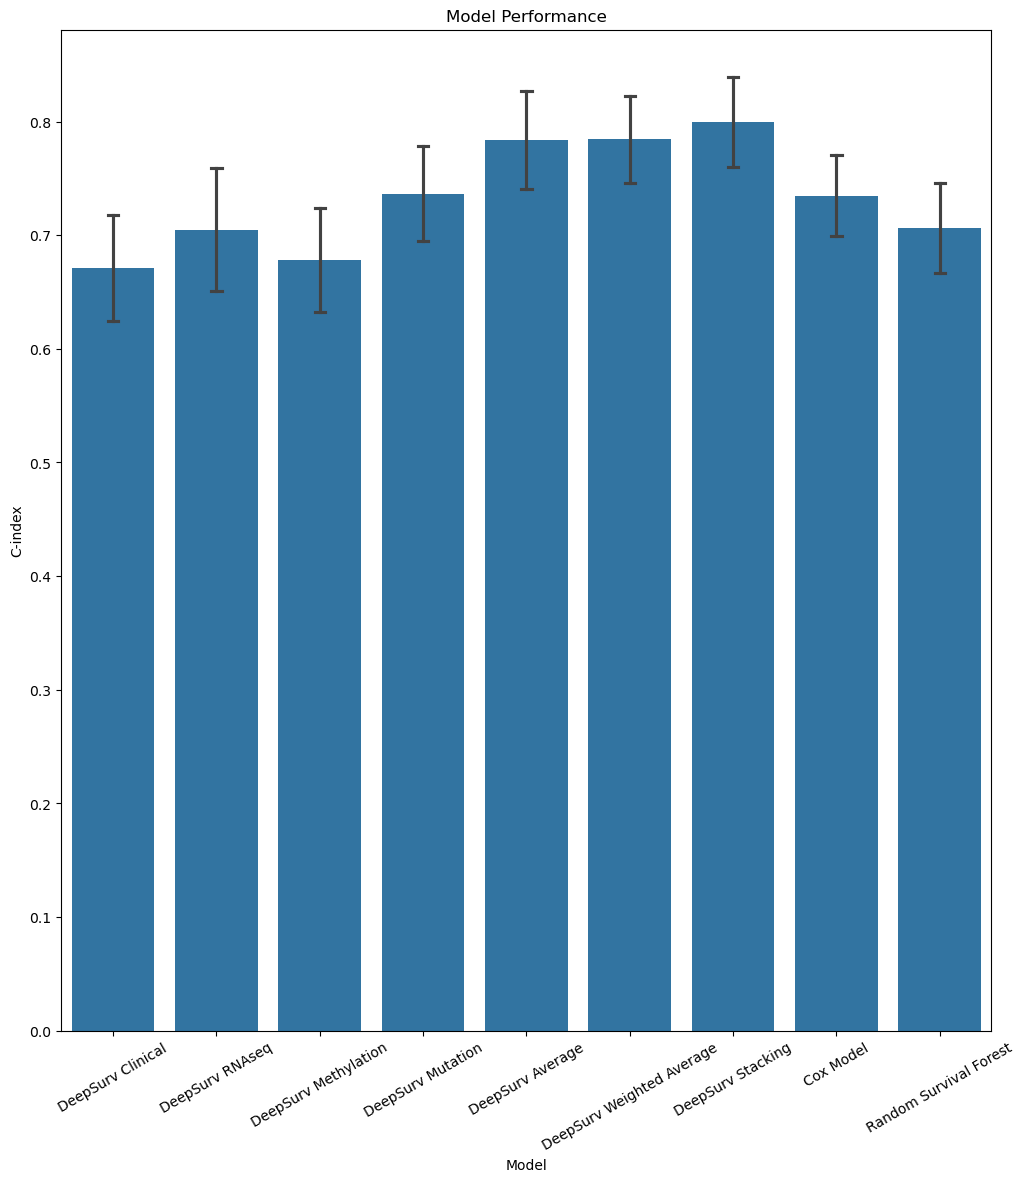

In [681]:
# Compile c-index of models
c_index_compile=pd.DataFrame({'DeepSurv Clinical': c_index_test_clinical, 'DeepSurv RNAseq': c_index_test_rnaseq,'DeepSurv Methylation': c_index_test_met,
                             'DeepSurv Mutation': c_index_test_mut,'DeepSurv Average': c_index_test_avg,'DeepSurv Weighted Average': c_index_test_w_avg,
                             'DeepSurv Stacking': c_index_test_meta,'Cox Model': c_index_test_cox,'Random Survival Forest': c_index_test_rf})

c_index_compile.to_csv('C Index Compile.csv', index=False)

# Plot c-index
# Melt the DataFrame to a long format for Seaborn
df_melted = c_index_compile.melt(var_name='Model', value_name='C-index')

# Create a bar plot using seaborn with standard error bars
plt.figure(figsize=(12, 13))
sns.barplot(x='Model', y='C-index', data=df_melted, errorbar='sd', capsize=0.1)

# Customize plot
plt.title('Model Performance')
plt.xlabel('Model')
plt.ylabel('C-index')
plt.xticks(rotation=30)
# Saving the figure.
plt.savefig("Model Comparison.jpg", dpi=300)
plt.show()

## Conclusions

- DeepSurv stacking using a meta model is the best performing model. Stacking is the best ensemble method for this data set.
- Ensembling methods improve the models' accuracies significantly.
- DeepSurv models outperform Cox proportional hazard and Random Survival Forest models.
- This project has built and optimized a deep learning model integrating clinical, RNA sequencing, Methylation, and Mutation data of Lung cancer patients to predict their survival risk with high accuracy.